In [4]:
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import os

In [5]:

class ChanelAttention(nn.Module):
    def __init__(self, in_c, ratio):
        super().__init__()
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.maxpool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Conv2d(in_c, in_c//ratio, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_c//ratio, in_c, kernel_size=1, bias=False)
        )
        
    def forward(self, x):
        avg_x = self.fc(self.avgpool(x))
        max_x = self.fc(self.maxpool(x))
        out = avg_x + max_x
        return torch.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return torch.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_c, ratio=8):
        super().__init__()
        self.CA = ChanelAttention(in_c, ratio)
        self.SA = SpatialAttention()
        
    def forward(self, x):
        x = x * self.CA(x)
        x = x * self.SA(x)
        return x

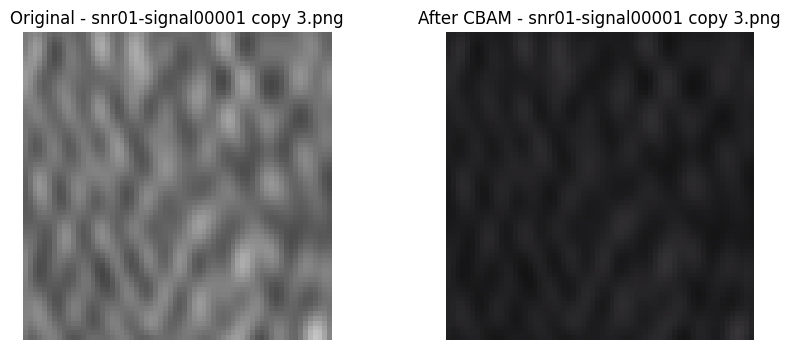

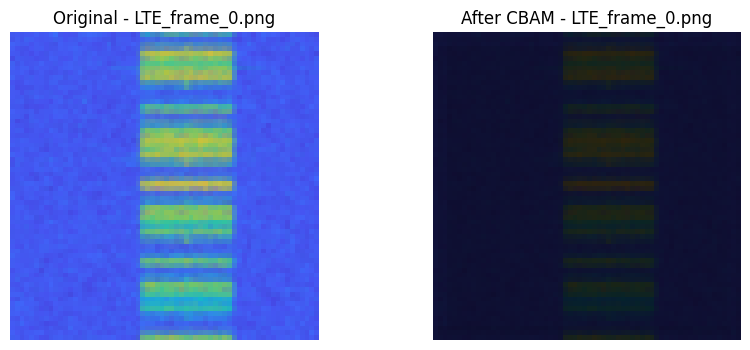

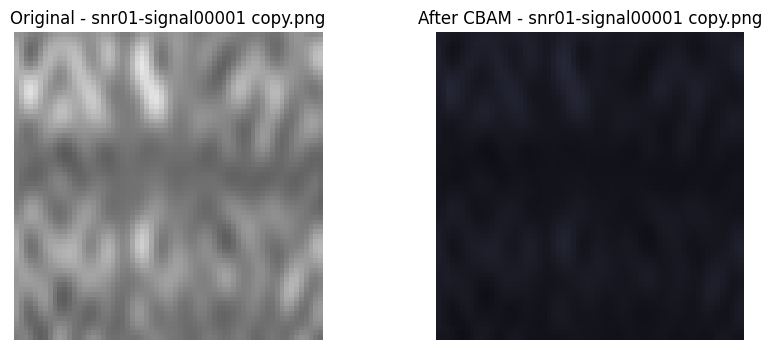

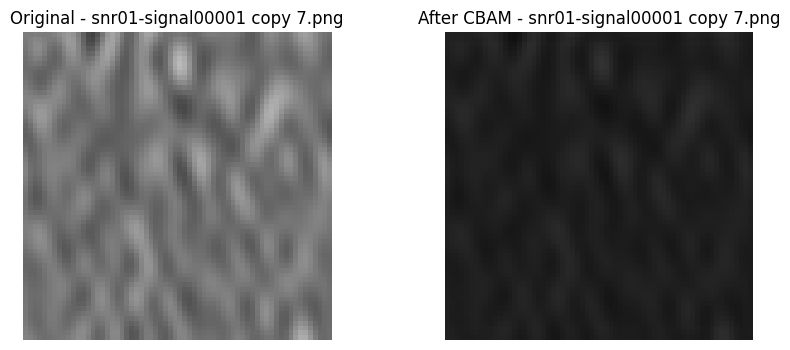

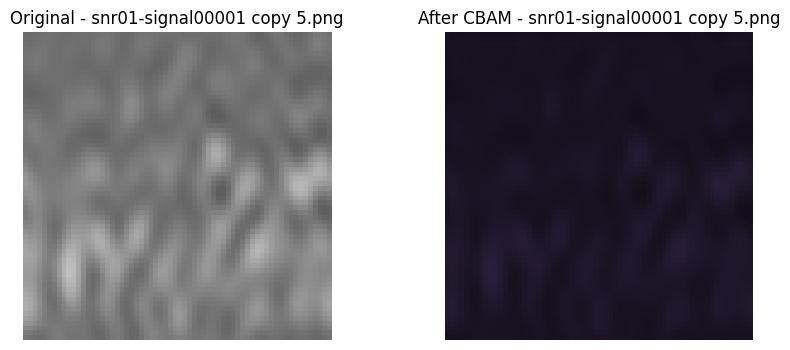

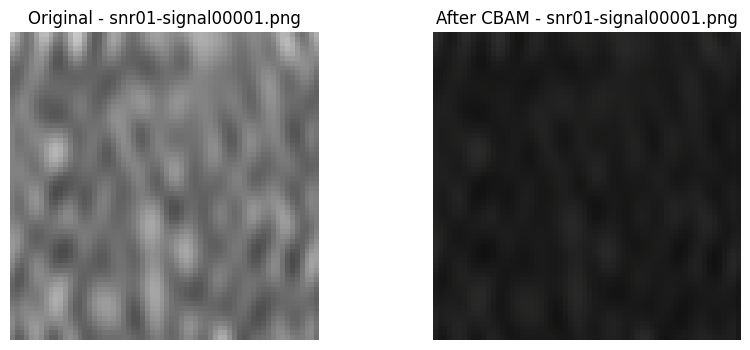

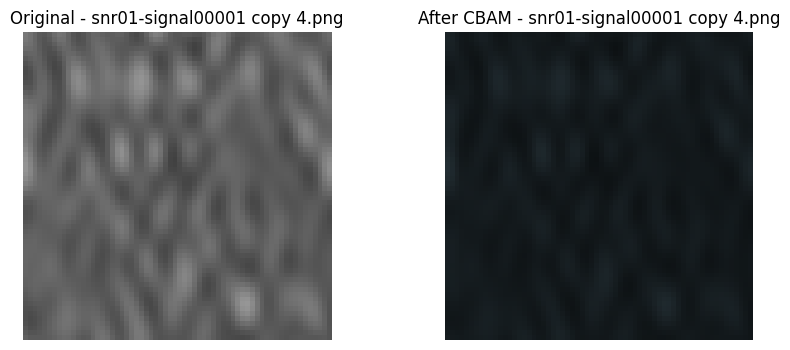

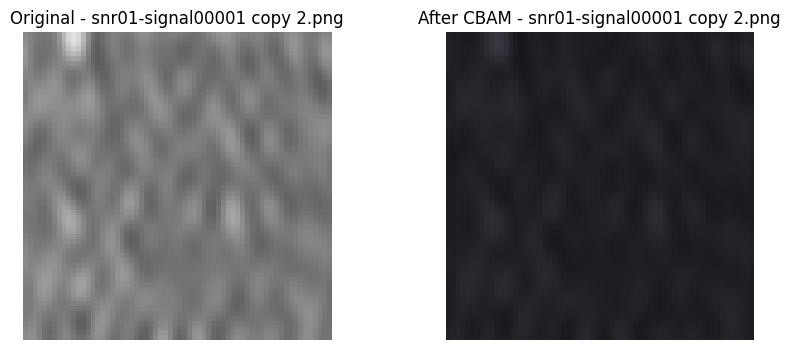

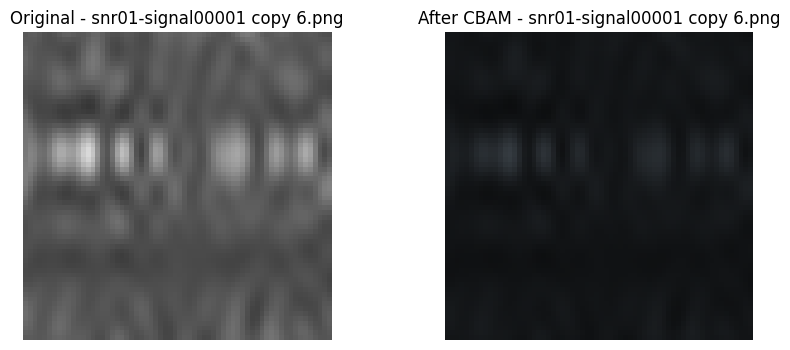

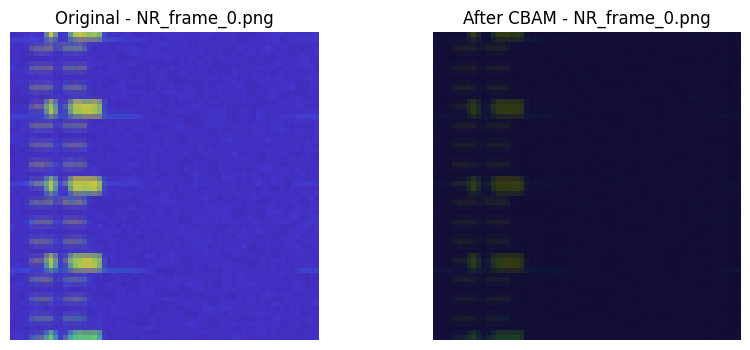

In [6]:
img_folder = '/home/vydat/Code/ML_AI/Source/img'

for img_name in os.listdir(img_folder):
    img_path = os.path.join(img_folder, img_name)
    
    if img_path.endswith(('.png', '.jpg', '.jpeg')): 
        image = Image.open(img_path).convert('RGB')

        transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor()
        ])

        img_tensor = transform(image).unsqueeze(0)

        cbam = CBAM(in_c=3, ratio=1)
        cbam.eval()

        with torch.no_grad():
            out_tensor = cbam(img_tensor).squeeze().clamp(0, 1)

        def tensor_to_image(tensor):
            return tensor.permute(1, 2, 0).cpu().numpy()

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.title(f'Original - {img_name}')
        plt.imshow(tensor_to_image(img_tensor.squeeze()))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title(f'After CBAM - {img_name}')
        plt.imshow(tensor_to_image(out_tensor))
        plt.axis('off')

        plt.show()